### Análise exploratória

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [221]:
heart_data = pd.read_csv('test_data_CANDIDATE.csv')
heart_data.head()

,index,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,nar,hc,sk,trf
0,0,49,M,10000,130,269.0,0,1,163,0,0.0,2.0,0,2,2,0,1,6797.761892
1,1,61,F,10000,138,166.0,0,0,125,1,3.6,NaN,1,2,2,1,3,4307.686943
2,2,46,F,10000,140,311.0,0,1,120,1,1.8,NaN,2,3,2,0,1,4118.077502
3,3,69,F,10000,140,254.0,0,0,146,0,2.0,1.0,3,3,2,1,0,7170.849469
4,4,51,F,10000,100,222.0,0,1,143,1,1.2,1.0,0,2,2,1,0,5579.040145


In [5]:
heart_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 18 columns):
index       288 non-null int64
age         288 non-null int64
sex         288 non-null object
cp          288 non-null int64
trestbps    288 non-null int64
chol        272 non-null float64
fbs         288 non-null int64
restecg     288 non-null int64
thalach     288 non-null int64
exang       288 non-null int64
oldpeak     288 non-null float64
slope       145 non-null float64
ca          288 non-null int64
thal        288 non-null int64
nar         288 non-null int64
hc          288 non-null int64
sk          288 non-null int64
trf         288 non-null float64
dtypes: float64(4), int64(13), object(1)
memory usage: 40.6+ KB


Nota-se que todas as colunas, com execeção da que queremos classificar (sex), são numéricas, boas notícias ;-)

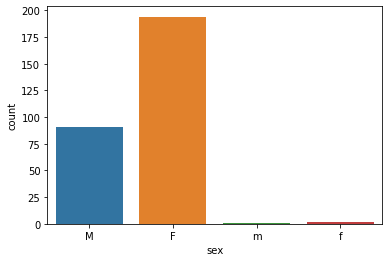

In [222]:
sns.countplot(x='sex', data=heart_data)

Como pode ser observado, temos F e M também em minúsculo, o que será necessário tratarmos depois. Outra importante observação é que o dataset é extremamente desbalanceado, com o número de samples femininas sendo mais de 2x maior que o de sample masculinas. Para treinar um modelo com menor bias, é importante possuirmos o mesmo número de samples de cada classe.

In [8]:
heart_data.isnull().sum()

index         0
age           0
sex           0
cp            0
trestbps      0
chol         16
fbs           0
restecg       0
thalach       0
exang         0
oldpeak       0
slope       143
ca            0
thal          0
nar           0
hc            0
sk            0
trf           0
dtype: int64

Aqui é possível notar que a coluna 'chol' possui 16 valores nulos e a coluna 'slope' 143. Farei o tratamento disto em seguida. Na coluna **'slope'** são muitos valores nulos, com quase metade das linhas nulas, o que parece preocupante. De antemão, acredito que dropar esta coluna seja mais prudente, já que a média ou moda possa não representar os dados muito bem.

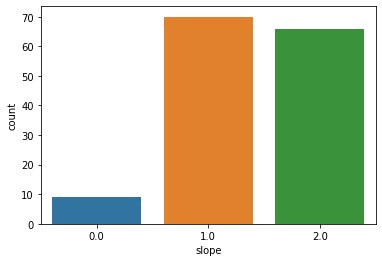

In [224]:
sns.countplot(x='slope', data=heart_data)

A coluna 'slope' apresenta valores categoricos, que na documentacao indicam ser 0 = upsloping, 1 = flat e 2 = downsloping. Para substituir valores ausentes a moda é uma ideia interessante, já que, por se tratar de uma variável nominal, a média e mediana não se aplicam.

In [41]:
heart_data['cp'].value_counts()

10000    288
Name: cp, dtype: int64

Nesta coluna, que deveria indicar o tipo de dor no peito do paciente, temos apenas um valor (10000) que não nos diz muita coisa, trazendo apenas ruído. É uma coluna fortemente candidata a ser descartada antes de os dados servirem de treino em um modelo.

In [43]:
heart_data['nar'].value_counts()

2    283
0      3
1      2
Name: nar, dtype: int64

A coluna 'nar' indica o número de braços que o paciente possui, para classificação de sexo que almejamos parece ser insignificante, pois qualquer ser humano, independente do sexo, pode ter um número variável de braços, digamos assim. Além disso, mesmo que fosse importante, a quantidade de samples é muito desbalanceada, que tornaria muito difícil um modelo extrair alguma informação importante para a classificação.

### Preprocessamento

In [206]:
from sklearn.impute import SimpleImputer
from sklearn.utils import resample

#1 tirar features que nao fazem sentido
#2 transformar sexo pra minusculo
#3 balancear

#transformando a coluna 'sex' para caracteres minusculos
heart_data['sex'] = [gender.lower() for gender in heart_data['sex']]

#conjunto de features a ser utilizado pelos modelos
#dropando colunas nao importantes, index, numero de braços e cp
X = heart_data.drop(columns=['sex', 'nar', 'index', 'cp', 'slope'])

#inputter a ser utilizado
inputer = SimpleImputer(strategy='most_frequent')

#substituindo valores nulos pela moda
X_inputted = pd.DataFrame(columns=X.columns, data=inputer.fit_transform(X))

#readicionando a coluna sex
X_inputted['sex'] = heart_data['sex']

#separando samples por sexo
df_maiority_f = X_inputted.query("sex == 'f'")
df_minority_m = X_inputted.query("sex == 'm'")

#realizando sample aleatorio de quantidade igual a de homens
maiority_sample = resample(df_maiority_f, replace=True, n_samples=92, random_state=33)
processed_data = pd.concat([maiority_sample, df_minority_m])

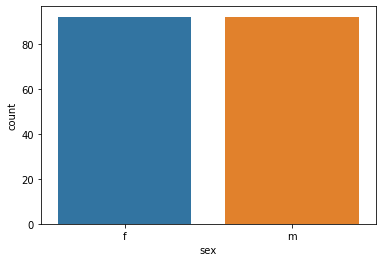

In [223]:
sns.countplot(x='sex', data=processed_data)

Pode-se ver que o dataset foi balanceado e possui a mesma quantidade de samples masculinas e femininas.

### Construção de um modelo

In [207]:
from sklearn.metrics import classification_report, plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X = processed_data.drop(columns='sex')
y = processed_data['sex']

#dividindo o dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Para construir este modelo estarei usando o **Random Forest**, um algoritmo que utiliza *n* árvores de decisão, ou seja, é um algoritmo de *ensemble* onde a decisão da maioria das árvores é a que será a final. Pelo fato de ser um modelo de *ensemble* ele evita *overfitting* pois a decisão de muitas árvores é melhor que a de somente uma árvore, reduzindo, assim a variância.

In [212]:
rf = RandomForestClassifier(random_state=33)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
print(classification_report(y_test, rf_preds))

              precision    recall  f1-score   support

           f       0.86      0.83      0.85        30
           m       0.81      0.85      0.83        26

    accuracy                           0.84        56
   macro avg       0.84      0.84      0.84        56
weighted avg       0.84      0.84      0.84        56



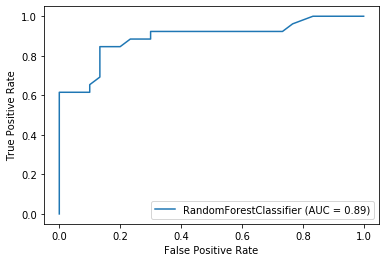

In [225]:
roc = plot_roc_curve(rf, X_test, y_test)

Nota-se que o modelo perfoma bem, com acurácia de 84% e e f1-score de 0.84. Acima a curva ROC e AUC que ambos são  bons. Quanto mais pra esquerda no topo a curva, menor a quantidade de falsos positivos por verdadeiros positivos.

In [214]:
importances = pd.DataFrame(rf.feature_importances_, index = X_train.columns,
                            columns=['importance']).sort_values('importance', ascending=False)
importances

,importance
thal,0.156047
chol,0.143025
hc,0.127041
thalach,0.107048
trf,0.105534
trestbps,0.086818
age,0.075285
oldpeak,0.073789
ca,0.038289
sk,0.036934


In [215]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rf, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.2000 ± 0.1116,thal
0.1250 ± 0.0814,hc
0.1071 ± 0.0598,chol
0.0393 ± 0.0267,oldpeak
0.0321 ± 0.0267,thalach
0.0321 ± 0.0143,trestbps
0.0179 ± 0.0319,ca
0.0143 ± 0.0267,exang
0.0107 ± 0.0286,restecg
0.0071 ± 0.0175,trf
